# Regression modeling on minimal features dataset

In [1]:
import warnings
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from yellowbrick.regressor import residuals_plot, ResidualsPlot
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
import json
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline


# Model types 
    * ElasticNet
    * SVM
    * AdaBoost
    * RandomForest
    * Multilayer Perceptron
    * Model validation
    * Save for deployment

In [2]:
df_min = pd.read_csv("../data/dataset_minimal_features_for_modeling.csv")
print(df_min.shape)
df_min.head(n=2)


(83658, 40)


,School_Type_1.0,School_Type_4.0,Enrollment Teacher_Ratio2,Highest_Grade_Offered Rla_Pct_Part,Rla_Pct_Part^2,Rla_Pct_Part,Reduced_Price_Lunch Teacher_Ratio2,Teacher_Ratio2,Math_Pct_Part Rla_Pct_Part,Teacher_Ratio1,...,School_Level_4.0,Urban_Centric_Locale_12.0,School_Level_3.0,Virtual_0.0,School_Type_3.0,Grad_Rate,Ncessch,Year,Schnam,Stnam
0,1,0,221.627990,1170.0,9506.25,97.5,12.263999,0.438000,9506.25,0.064921,...,1,0,0,1,0,52.0,20000100208,2012,Bethel Regional High School,ALASKA
1,0,1,8.714286,1080.0,8100.00,90.0,0.000000,0.142857,8100.00,0.065574,...,0,0,1,1,0,10.0,20000100318,2012,Bethel Alternative Boarding School,ALASKA


In [3]:
# Split data into test & train
y = df_min.pop('Grad_Rate')
X = df_min
X.drop(["Ncessch", "Year", "Schnam", "Stnam"], axis=1, inplace=True)

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)


In [4]:
X.dtypes


School_Type_1.0                         int64
School_Type_4.0                         int64
Enrollment Teacher_Ratio2             float64
Highest_Grade_Offered Rla_Pct_Part    float64
Rla_Pct_Part^2                        float64
Rla_Pct_Part                          float64
Reduced_Price_Lunch Teacher_Ratio2    float64
Teacher_Ratio2                        float64
Math_Pct_Part Rla_Pct_Part            float64
Teacher_Ratio1                        float64
Free_Lunch                            float64
Civilian_Labor_Force                  float64
All_Cohort                              int64
Enrollment                            float64
Free_Or_Reduced_Price_Lunch           float64
Teachers_Fte                          float64
Reduced_Price_Lunch                   float64
Math_Pct_Part                         float64
Unemployment_Rate                     float64
Title_I_Status_5.0                      int64
Charter_0.0                             int64
Lowest_Grade_Offered              

In [5]:
def display_grid_results(results):
    """ Print out the GridSearchCV results """
    print(f'Best parameters are: {results.best_params_}')
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean, std, params in zip(mean_score, std_score, params):
        print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')


In [6]:
def append_to_model_params_log(string_id, obj):
    """ Save data as json to the model_best_parameters log file"""
    json.dump(string_id, open(
        "../logs/model_best_parameters.json", mode='a'))
    json.dump(obj, open(
        "../logs/model_best_parameters.json", mode='a'))


## ElasticNet (Generalized Linear Model)

In [7]:
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                       variables=Xtrain.columns.to_list())
min_max_scaler = SklearnTransformerWrapper(transformer=MinMaxScaler(),
                                           variables=Xtrain.columns.to_list())

pipe_elastic = Pipeline(steps=[("scale", std_scaler),
                               ("general_linear",
                               ElasticNetCV(
                                l1_ratio=[0.1, 0.4, 0.7, 1.0],
                                random_state=42,
                                max_iter=2000,
                                n_jobs=4,
                                cv=10))
                               ])


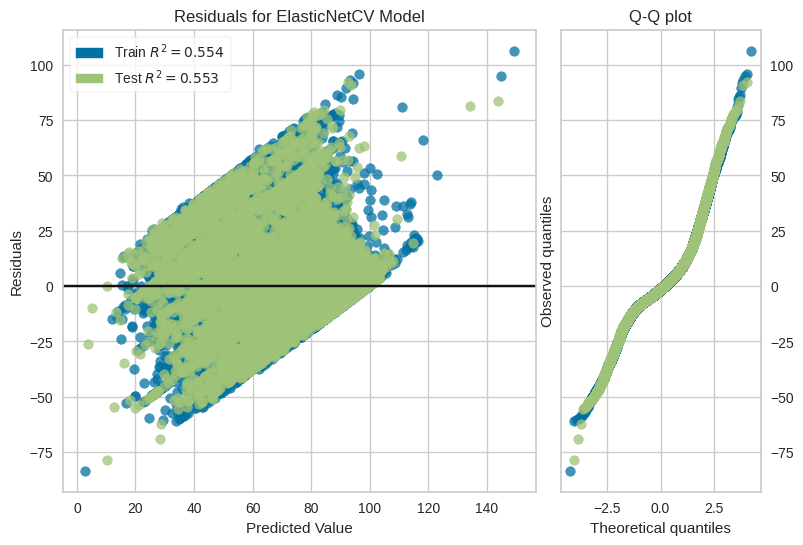

RMSE 12.994482654980393


In [8]:
def make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe):
    grid_results = pipe.fit(Xtrain, ytrain)
    plt.rcParams['figure.figsize'] = (9, 6)
    visualizer = ResidualsPlot(pipe, hist=False, qqplot=True)
    visualizer.fit(Xtrain, ytrain)
    visualizer.score(Xtest, ytest)
    visualizer.show()
    print("RMSE", mean_squared_error(
        ytest, visualizer.estimator.predict(Xtest), squared=False))
    return grid_results


elastic_grid_results = make_residual_plot_and_print_rmse(
    Xtrain, ytrain, Xtest, ytest, pipe_elastic)


In [9]:
pipe_elastic._final_estimator.l1_ratio_

1.0

# Support Vector Machine (SVR)

In [10]:
pipe_svm = Pipeline(steps=[("scale", std_scaler), ("svr", SVR())])

param_grid = {
    "svr__epsilon": [0.2, 0.4, 0.6],
    "svr__C": [3, 5, 7],
    "svr__kernel": ["rbf"],
}


local_model_path = (
    "../../student_outcome_saved_models/model_minimal_features_svr_gridsearch2.pkl"
)
clf = {}
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe_svm,
        param_grid,
        n_jobs=6,
        verbose=3,
        cv=10,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)
    append_to_model_params_log("Minimal Features", clf.best_params_)


In [11]:
print(clf.best_params_)
display_grid_results(clf)
del clf


{'svr__C': 7, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}
Best parameters are: {'svr__C': 7, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}
0.64 + or -0.01 for the {'svr__C': 3, 'svr__epsilon': 0.2, 'svr__kernel': 'rbf'}
0.64 + or -0.01 for the {'svr__C': 3, 'svr__epsilon': 0.4, 'svr__kernel': 'rbf'}
0.64 + or -0.01 for the {'svr__C': 3, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}
0.65 + or -0.01 for the {'svr__C': 5, 'svr__epsilon': 0.2, 'svr__kernel': 'rbf'}
0.65 + or -0.01 for the {'svr__C': 5, 'svr__epsilon': 0.4, 'svr__kernel': 'rbf'}
0.65 + or -0.01 for the {'svr__C': 5, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}
0.66 + or -0.01 for the {'svr__C': 7, 'svr__epsilon': 0.2, 'svr__kernel': 'rbf'}
0.66 + or -0.01 for the {'svr__C': 7, 'svr__epsilon': 0.4, 'svr__kernel': 'rbf'}
0.66 + or -0.01 for the {'svr__C': 7, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}


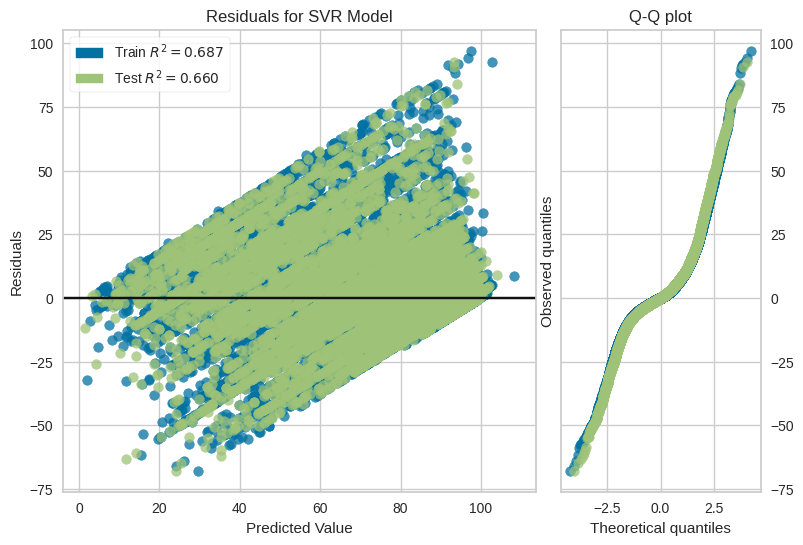

RMSE 11.335941455829168


Pipeline(steps=[('scale',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['School_Type_1.0',
                                                      'School_Type_4.0',
                                                      'Enrollment '
                                                      'Teacher_Ratio2',
                                                      'Highest_Grade_Offered '
                                                      'Rla_Pct_Part',
                                                      'Rla_Pct_Part^2',
                                                      'Rla_Pct_Part',
                                                      'Reduced_Price_Lunch '
                                                      'Teacher_Ratio2',
                                                      'Teacher_Ratio2',
                                                      'Math_Pct_Part '
                                                      'Rla_Pct_Part',
                                                      'Teacher_Ratio1',
                                                      'Free_Lunch',
                                                      'Civilian...
                                                      'Free_Or_Reduced_Price_Lunch',
                                                      'Teachers_Fte',
                                                      'Reduced_Price_Lunch',
                                                      'Math_Pct_Part',
                                                      'Unemployment_Rate',
                                                      'Title_I_Status_5.0',
                                                      'Charter_0.0',
                                                      'Lowest_Grade_Offered',
                                                      'Urban_Centric_Locale_11.0',
                                                      'Num_Grades',
                                                      'Virtual_1.0',
                                                      'Metro_Or_Not_0.0',
                                                      'Rural_Urban_Continuum_Code_1.0',
                                                      'Urban_Influence_Code_1.0',
                                                      'Title_I_Eligible_1.0',
                                                      'Title_I_Status_6.0', ...])),
                ('svr', SVR(C=7, epsilon=0.6))])

In [12]:
pipe_svm = Pipeline(steps=[("scale", std_scaler),
                    ("svr", SVR(C=7, epsilon=0.6, kernel="rbf"))])
make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe_svm)


# Multilayer Perceptron 

In [13]:
pipe_mlpr = Pipeline(steps=[("scale", std_scaler),
                     ("mlpr", MLPRegressor(max_iter=400,random_state=42))])

param_grid = {"mlpr__hidden_layer_sizes": [(50,), (100,)], "mlpr__activation": [
    "logistic", "tanh", "relu"], "mlpr__solver": ["sgd", "adam"], "mlpr__alpha": [0.0001, 0.0002]}

local_model_path = (
    "../../student_outcome_saved_models/model_minimal_features_mlpr_gridsearch1.pkl"
)
clf = {}
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe_mlpr,
        param_grid,
        n_jobs=5,
        verbose=3,
        cv=10,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)
    append_to_model_params_log("Minimal Features", clf.best_params_)


In [14]:
display_grid_results(clf)
del clf


Best parameters are: {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (100,), 'mlpr__solver': 'sgd'}
0.69 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (50,), 'mlpr__solver': 'sgd'}
0.67 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (50,), 'mlpr__solver': 'adam'}
0.7 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (100,), 'mlpr__solver': 'sgd'}
0.68 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (100,), 'mlpr__solver': 'adam'}
0.69 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0002, 'mlpr__hidden_layer_sizes': (50,), 'mlpr__solver': 'sgd'}
0.67 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0002, 'mlpr__hidden_layer_sizes': (50,), 'mlpr__solver': 'adam'}
0.7 + or -0.01 for the {'mlpr__a

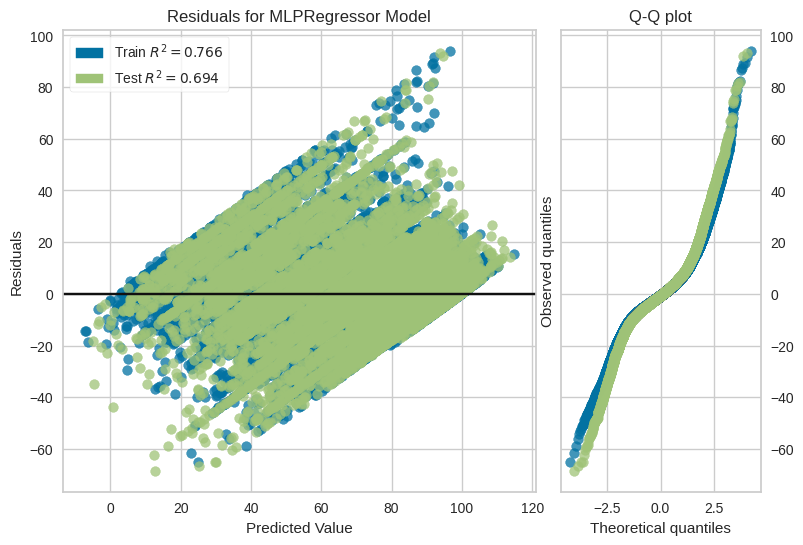

RMSE 10.748302837507039


Pipeline(steps=[('scale',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['School_Type_1.0',
                                                      'School_Type_4.0',
                                                      'Enrollment '
                                                      'Teacher_Ratio2',
                                                      'Highest_Grade_Offered '
                                                      'Rla_Pct_Part',
                                                      'Rla_Pct_Part^2',
                                                      'Rla_Pct_Part',
                                                      'Reduced_Price_Lunch '
                                                      'Teacher_Ratio2',
                                                      'Teacher_Ratio2',
                                                      'Math_Pct_Part '
                                                      'Rla_Pct_Part',
                                                      'Teacher_Ratio1',
                                                      'Free_Lunch',
                                                      'Civilian...
                                                      'Unemployment_Rate',
                                                      'Title_I_Status_5.0',
                                                      'Charter_0.0',
                                                      'Lowest_Grade_Offered',
                                                      'Urban_Centric_Locale_11.0',
                                                      'Num_Grades',
                                                      'Virtual_1.0',
                                                      'Metro_Or_Not_0.0',
                                                      'Rural_Urban_Continuum_Code_1.0',
                                                      'Urban_Influence_Code_1.0',
                                                      'Title_I_Eligible_1.0',
                                                      'Title_I_Status_6.0', ...])),
                ('mlpr',
                 MLPRegressor(activation='logistic', alpha=0.0002,
                              max_iter=1000, random_state=42, solver='sgd'))])

In [15]:
pipe_mlpr = Pipeline(steps=[("scale", std_scaler),
                            ("mlpr", MLPRegressor(activation='logistic',
                                                  alpha=0.0002, hidden_layer_sizes=(100,),
                                                  solver='sgd', max_iter=1000, random_state=42))])


make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe_mlpr)


# Adaboost

In [16]:
pipe_adar = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(random_state=42))

param_grid = {'n_estimators': [800],
              'base_estimator__max_features': [0.3, 0.9],
              'base_estimator__max_depth': [9, 11],
              'learning_rate': [0.1, 0.2],
              'loss': ['exponential']}


local_model_path = (
    "../../student_outcome_saved_models/model_minimal_features_adar_gridsearch2.pkl"
)

clf = {}
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe_adar,
        param_grid,
        n_jobs=5,
        verbose=3,
        cv=10,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)
    append_to_model_params_log(
        "Minimal Features - AdaBoostRegressor", clf.best_params_)


In [17]:
display_grid_results(clf)
del clf

Best parameters are: {'base_estimator__max_depth': 11, 'base_estimator__max_features': 0.9, 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 800}
0.55 + or -0.01 for the {'base_estimator__max_depth': 9, 'base_estimator__max_features': 0.3, 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 800}
0.48 + or -0.02 for the {'base_estimator__max_depth': 9, 'base_estimator__max_features': 0.3, 'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 800}
0.58 + or -0.02 for the {'base_estimator__max_depth': 9, 'base_estimator__max_features': 0.9, 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 800}
0.52 + or -0.02 for the {'base_estimator__max_depth': 9, 'base_estimator__max_features': 0.9, 'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 800}
0.68 + or -0.01 for the {'base_estimator__max_depth': 11, 'base_estimator__max_features': 0.3, 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 800}
0.66 + or -0.01 for the {'base_estimator_

/home/bb/miniconda3/envs/gr/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/bb/miniconda3/envs/gr/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


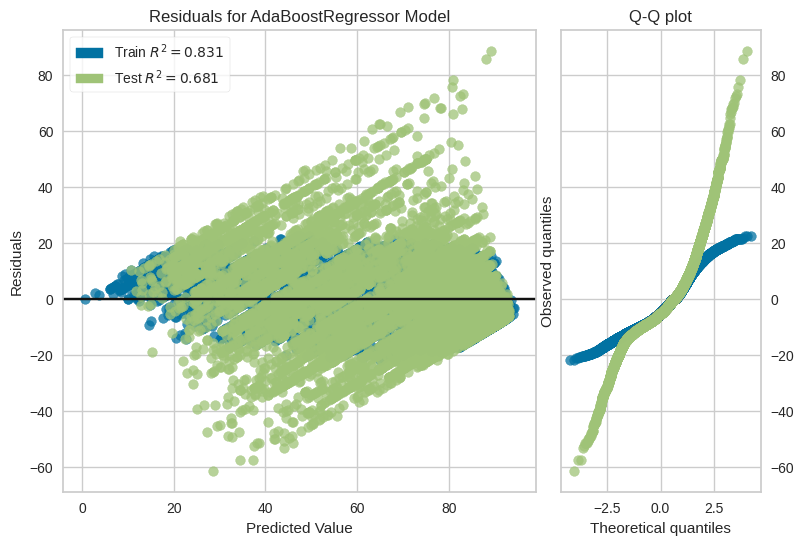

RMSE 10.985788079147982


Pipeline(steps=[('ada',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=11,
                                                                        max_features=0.9,
                                                                        random_state=42),
                                   learning_rate=0.1, loss='exponential',
                                   n_estimators=800))])

In [18]:
pipe_adar = Pipeline(steps=[("ada", AdaBoostRegressor(learning_rate=0.1, loss='exponential', n_estimators=800,
                     base_estimator=DecisionTreeRegressor(max_features=0.9, max_depth=11, random_state=42)))])
make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe_adar)


# Random Forest

In [19]:
pipe_rf = RandomForestRegressor(random_state=42)

param_grid = {'n_estimators': [500, 1000],
              'max_features': [0.1, 0.3, 0.8],
              'max_depth': [11, 12, 13],
              }


local_model_path = (
    "../../student_outcome_saved_models/model_minimal_features_rf_gridsearch1.pkl"
)

clf = {}
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe_rf,
        param_grid,
        n_jobs=10,
        verbose=3,
        cv=10,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)
    append_to_model_params_log(
        "Minimal Features - RandomForestRegressor", clf.best_params_)


In [20]:
display_grid_results(clf)
del clf


Best parameters are: {'max_depth': 13, 'max_features': 0.8, 'n_estimators': 1000}
0.67 + or -0.01 for the {'max_depth': 11, 'max_features': 0.1, 'n_estimators': 500}
0.67 + or -0.01 for the {'max_depth': 11, 'max_features': 0.1, 'n_estimators': 1000}
0.69 + or -0.01 for the {'max_depth': 11, 'max_features': 0.3, 'n_estimators': 500}
0.69 + or -0.01 for the {'max_depth': 11, 'max_features': 0.3, 'n_estimators': 1000}
0.69 + or -0.01 for the {'max_depth': 11, 'max_features': 0.8, 'n_estimators': 500}
0.69 + or -0.01 for the {'max_depth': 11, 'max_features': 0.8, 'n_estimators': 1000}
0.68 + or -0.01 for the {'max_depth': 12, 'max_features': 0.1, 'n_estimators': 500}
0.68 + or -0.01 for the {'max_depth': 12, 'max_features': 0.1, 'n_estimators': 1000}
0.7 + or -0.01 for the {'max_depth': 12, 'max_features': 0.3, 'n_estimators': 500}
0.7 + or -0.01 for the {'max_depth': 12, 'max_features': 0.3, 'n_estimators': 1000}
0.7 + or -0.01 for the {'max_depth': 12, 'max_features': 0.8, 'n_estimators

# Validation Curves

In [21]:
from yellowbrick.model_selection import validation_curve
path_val_curve = "../../student_outcome_saved_models/rf_validation_curve_max_depth1"
if os.path.exists(path_val_curve):
    viz = joblib.load(path_val_curve)
else:
    viz = validation_curve(
        RandomForestRegressor(max_features=0.8, n_estimators=800, n_jobs=4), X, y, param_name="max_depth",
        param_range=np.arange(5, 18, 4), cv=10, scoring="r2",
    )
    joblib.dump(
        viz, path_val_curve)


## Adding noise to investigate overfitting

In [22]:

def add_noise(X, y, fraction_of_std_dev=100, include_cats=False):
    """ Add noise to numerics in the dataset. fraction_of_std_dev=100 adds 1/100th of a std to every numeric. """
    Xnoise = X.copy()
    ynoise = y.copy()
    for col in X.columns:
        if X[col].dtype == 'float64' or include_cats:
            col_noise_std = X[col].std()/fraction_of_std_dev
            col_len = len(X[col])
            Xnoise[col] = X[col] + \
                np.random.normal(loc=0, scale=col_noise_std, size=col_len)
        else:
            # Leave categorics alone
            assert include_cats == False  # we should not hit this line if include_cats is true
            Xnoise[col] = X[col]
    # Add noise to y
    ynoise = y + \
        np.random.normal(loc=0, scale=y.std()/fraction_of_std_dev, size=len(y))
    # Return noisy data
    return Xnoise, ynoise


## Inspect what 1/400th std of noise does to the distributions

In [23]:
Xnoise, ynoise = add_noise(X,y,fraction_of_std_dev=400,include_cats=True)
X.head()


,School_Type_1.0,School_Type_4.0,Enrollment Teacher_Ratio2,Highest_Grade_Offered Rla_Pct_Part,Rla_Pct_Part^2,Rla_Pct_Part,Reduced_Price_Lunch Teacher_Ratio2,Teacher_Ratio2,Math_Pct_Part Rla_Pct_Part,Teacher_Ratio1,...,Metro_Or_Not_0.0,Rural_Urban_Continuum_Code_1.0,Urban_Influence_Code_1.0,Title_I_Eligible_1.0,Title_I_Status_6.0,School_Level_4.0,Urban_Centric_Locale_12.0,School_Level_3.0,Virtual_0.0,School_Type_3.0
0,1,0,221.627990,1170.0,9506.25,97.5,12.263999,0.438000,9506.25,0.064921,...,1,0,0,1,0,1,0,0,1,0
1,0,1,8.714286,1080.0,8100.00,90.0,0.000000,0.142857,8100.00,0.065574,...,1,0,0,1,0,0,0,1,1,0
2,1,0,126.126761,1170.0,9506.25,97.5,11.091549,0.316901,9506.25,0.056533,...,1,0,0,1,0,0,0,1,1,0
3,1,0,34.065882,1080.0,8100.00,90.0,1.792941,0.448235,8100.00,0.100263,...,1,0,0,1,0,0,0,1,1,0
4,1,0,70.616664,1140.0,9025.00,95.0,8.362500,0.464583,9025.00,0.073355,...,1,0,0,1,0,0,0,1,1,0


In [24]:
Xnoise.head()

,School_Type_1.0,School_Type_4.0,Enrollment Teacher_Ratio2,Highest_Grade_Offered Rla_Pct_Part,Rla_Pct_Part^2,Rla_Pct_Part,Reduced_Price_Lunch Teacher_Ratio2,Teacher_Ratio2,Math_Pct_Part Rla_Pct_Part,Teacher_Ratio1,...,Metro_Or_Not_0.0,Rural_Urban_Continuum_Code_1.0,Urban_Influence_Code_1.0,Title_I_Eligible_1.0,Title_I_Status_6.0,School_Level_4.0,Urban_Centric_Locale_12.0,School_Level_3.0,Virtual_0.0,School_Type_3.0
0,0.999242,0.000386,221.461248,1169.749558,9503.693062,97.483036,12.244306,0.437996,9508.665117,0.064849,...,0.997802,0.002527,-0.000754,0.999351,-0.002614,0.999179,-0.000410,0.000257,0.998820,-0.000026
1,0.000375,1.000662,7.625833,1079.435350,8098.772286,90.045176,-0.015979,0.143031,8102.375346,0.065434,...,0.998905,0.000420,-0.000908,1.000656,-0.000615,-0.001204,-0.000088,0.999833,1.001439,0.000015
2,0.999446,0.000697,126.506788,1169.819425,9503.667212,97.501136,11.141032,0.318157,9509.857167,0.056482,...,0.999431,-0.000380,0.000638,0.998964,0.002360,-0.000686,-0.001192,1.000175,0.999828,0.000024
3,0.999504,0.000936,33.935391,1079.611423,8101.239500,89.996307,1.819545,0.449393,8102.189116,0.100386,...,0.999279,0.001485,-0.000761,0.999976,-0.000038,-0.000506,0.001036,1.000559,1.000309,-0.000087
4,1.000263,-0.001369,70.745978,1140.776631,9021.825382,94.982073,8.409322,0.464443,9024.135276,0.073351,...,0.999954,0.000332,-0.001488,0.998532,0.001180,0.000089,-0.000741,0.998269,1.000120,0.000125


In [25]:
X.shape, Xnoise.shape, y.shape, ynoise.shape


((83658, 35), (83658, 35), (83658,), (83658,))

In [26]:
X.describe()


,School_Type_1.0,School_Type_4.0,Enrollment Teacher_Ratio2,Highest_Grade_Offered Rla_Pct_Part,Rla_Pct_Part^2,Rla_Pct_Part,Reduced_Price_Lunch Teacher_Ratio2,Teacher_Ratio2,Math_Pct_Part Rla_Pct_Part,Teacher_Ratio1,...,Metro_Or_Not_0.0,Rural_Urban_Continuum_Code_1.0,Urban_Influence_Code_1.0,Title_I_Eligible_1.0,Title_I_Status_6.0,School_Level_4.0,Urban_Centric_Locale_12.0,School_Level_3.0,Virtual_0.0,School_Type_3.0
count,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.00000,83658.000000,...,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000
mean,0.891427,0.093811,242.825220,1119.637034,8792.399543,93.261302,15.720995,0.343614,8768.93235,0.069531,...,0.276292,0.420581,0.420581,0.670743,0.329257,0.096452,0.053002,0.903536,0.909764,0.006586
std,0.311105,0.291567,324.019488,117.094513,1476.740350,9.732946,25.890115,0.323200,1486.04309,0.032809,...,0.447165,0.493655,0.493655,0.469946,0.469946,0.295212,0.224038,0.295229,0.286522,0.080889
min,0.000000,0.000000,0.076923,30.000000,6.250000,2.500000,0.000000,0.001920,6.25000,0.000438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,88.284624,1104.000000,8464.000000,92.000000,3.371534,0.210188,8550.00000,0.051622,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,1.000000,0.000000,181.593822,1170.000000,9506.250000,97.500000,10.228056,0.266973,9506.00000,0.063879,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,0.000000,335.736588,1170.000000,9506.250000,97.500000,20.293518,0.368716,9506.25000,0.079081,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,27487.698113,1293.500000,9900.250000,99.500000,1982.943396,14.911667,9900.25000,1.767273,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
Xnoise.describe()


,School_Type_1.0,School_Type_4.0,Enrollment Teacher_Ratio2,Highest_Grade_Offered Rla_Pct_Part,Rla_Pct_Part^2,Rla_Pct_Part,Reduced_Price_Lunch Teacher_Ratio2,Teacher_Ratio2,Math_Pct_Part Rla_Pct_Part,Teacher_Ratio1,...,Metro_Or_Not_0.0,Rural_Urban_Continuum_Code_1.0,Urban_Influence_Code_1.0,Title_I_Eligible_1.0,Title_I_Status_6.0,School_Level_4.0,Urban_Centric_Locale_12.0,School_Level_3.0,Virtual_0.0,School_Type_3.0
count,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,...,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000,83658.000000
mean,0.891428,0.093813,242.828015,1119.637181,8792.417193,93.261244,15.720921,0.343616,8768.941900,0.069532,...,0.276293,0.420582,0.420579,0.670736,0.329253,0.096450,0.053001,0.903537,0.909761,0.006587
std,0.311105,0.291567,324.015644,117.094171,1476.741140,9.733020,25.889875,0.323198,1486.066557,0.032809,...,0.447161,0.493654,0.493660,0.469952,0.469952,0.295216,0.224036,0.295228,0.286527,0.080890
min,-0.003040,-0.003244,-0.688658,29.549158,6.618131,2.476188,-0.275408,0.000819,2.102221,0.000391,...,-0.005580,-0.005183,-0.005723,-0.004860,-0.004750,-0.003018,-0.002331,-0.002532,-0.002379,-0.000940
25%,0.999222,-0.000432,88.321991,1104.433553,8469.093882,92.033552,3.371178,0.210105,8552.011973,0.051625,...,-0.000436,-0.000219,-0.000215,0.000806,-0.000390,-0.000444,-0.000354,0.999301,0.999325,-0.000135
50%,0.999878,0.000102,181.670761,1169.632234,9501.356098,97.468482,10.225178,0.266860,9498.859066,0.063872,...,0.000559,0.001362,0.001339,0.999229,0.000774,0.000097,0.000038,0.999898,0.999910,0.000002
75%,1.000452,0.000690,335.802999,1170.213784,9508.809184,97.516870,20.301407,0.368770,9508.727425,0.079083,...,0.998555,0.999709,0.999706,1.000383,0.999172,0.000705,0.000462,1.000438,1.000428,0.000140
max,1.003338,1.002673,27486.451723,1294.111086,9914.419630,99.593193,1982.949970,14.913127,9915.466824,1.767122,...,1.004461,1.005160,1.005821,1.004943,1.004423,1.002900,1.002244,1.003212,1.003032,1.000666


In [28]:
y.describe() - ynoise.describe()


count    0.000000
mean     0.000153
std      0.000159
min      0.051472
25%     -0.007687
50%      0.032123
75%      0.035113
max     -0.149438
Name: Grad_Rate, dtype: float64

# Check best model after adding noise to training set

/home/bb/miniconda3/envs/gr/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


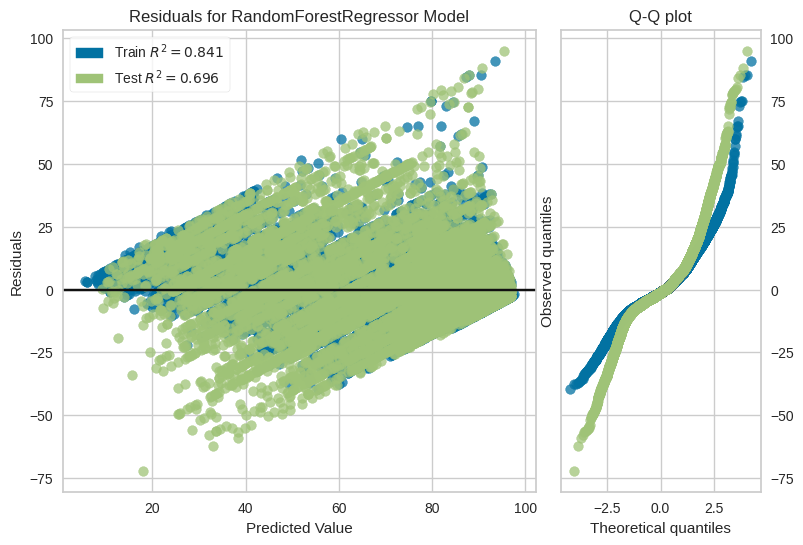

RMSE 10.71321509840757


Pipeline(steps=[('rf',
                 RandomForestRegressor(max_depth=13, max_features=0.8,
                                       n_estimators=1000, n_jobs=4,
                                       random_state=42))])

In [29]:
Xtrain_noise, ytrain_noise = add_noise(Xtrain,ytrain,fraction_of_std_dev=400,include_cats=True)
pipe_rf = Pipeline(steps=[("rf", RandomForestRegressor(
    max_depth=13, max_features=0.8, n_estimators=1000,n_jobs=4,random_state=42))])
make_residual_plot_and_print_rmse(Xtrain_noise, ytrain_noise, Xtest, ytest, pipe_rf)


## Deployment params

/home/bb/miniconda3/envs/gr/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


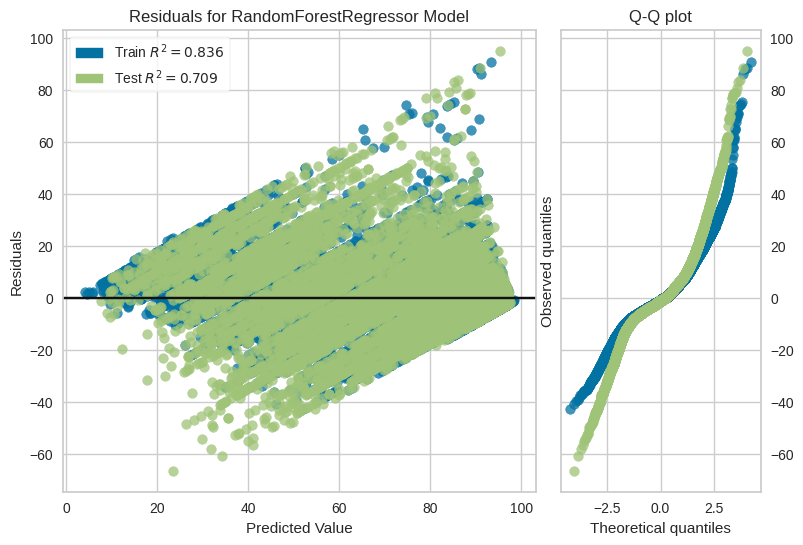

RMSE 10.48536274815377


Pipeline(steps=[('rf',
                 RandomForestRegressor(max_depth=13, max_features=0.8,
                                       n_estimators=1000, n_jobs=4,
                                       random_state=42))])

In [30]:
pipe_rf = Pipeline(steps=[("rf", RandomForestRegressor(
    max_depth=13, max_features=0.8, n_estimators=1000,n_jobs=4,random_state=42))])
make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe_rf)

# Train and save final model for deployment

In [31]:
# Save our best model for deployment
pipe_rf.fit(Xtrain, ytrain)
joblib.dump(pipe_rf, "../model_files/deployment_model_rf",compress=8)


['../model_files/deployment_model_rf']